In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
from scipy import stats
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
from sklearn.decomposition import PCA

<h1>Dataframe preparations</h1>

In [3]:
merged_df = pd.read_csv('/Users/rgu/Desktop/UROPs/UROP4/repo/dataframes/final505.csv')

<h1>Clustering</h1>

In [150]:
#Determine the colors of the points
colormap = {'blues': 'blue', 
          'classical': 'brown', 
          'country': 'orange', 
          'disco': 'purple', 
          'hiphop': 'skyblue', 
          'jazz': 'khaki', 
          'metal': 'black', 
          'pop': 'deeppink', 
          'reggae': 'green', 
          'rock': 'red'}

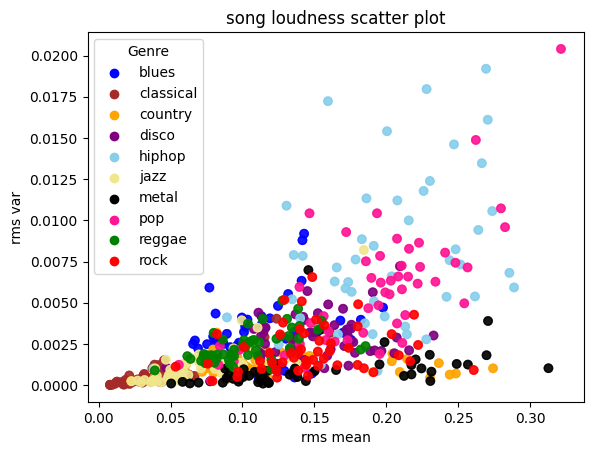

In [151]:
#plot the songs by RMS amplitude mean and variance as the axes. The points will be color coded by genre
x = merged_df['rms_mean']
y = merged_df['rms_var']
colors = merged_df['genre'].map(colormap)

plt.scatter(x, y, c=colors, alpha=0.7)  

plt.xlabel('rms mean')
plt.ylabel('rms var')
plt.title('song loudness scatter plot')


for genre, color in colormap.items():
    plt.scatter([], [], c=color, label=genre)
plt.legend(title="Genre")

plt.show()


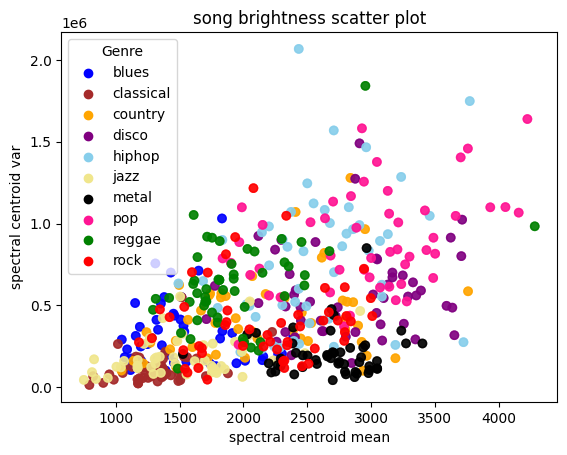

In [152]:
#plot the songs by spectral centroid mean and variance as the axes. The points will be color coded by genre
x = merged_df['spectral_centroid_mean']
y = merged_df['spectral_centroid_var']
colors = merged_df['genre'].map(colormap)

plt.scatter(x, y, c=colors, alpha=0.7)  

plt.xlabel('spectral centroid mean')
plt.ylabel('spectral centroid var')
plt.title('song brightness scatter plot')


for genre, color in colormap.items():
    plt.scatter([], [], c=color, label=genre)
plt.legend(title="Genre")

plt.show()

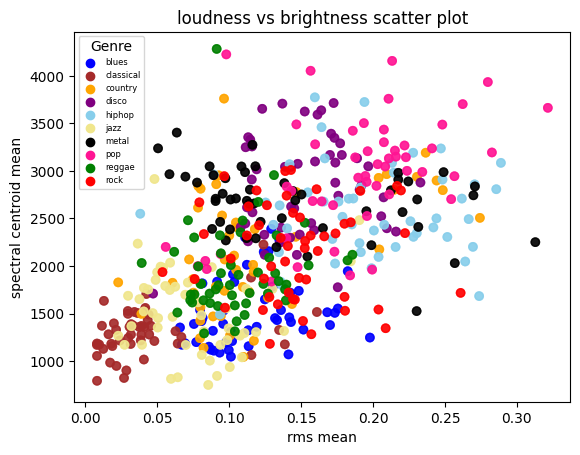

In [153]:
#plot the songs by RMS amplitude mean and spectral centroid as the axes. The points will be color coded by genre
x = merged_df['rms_mean']
y = merged_df['spectral_centroid_mean']
colors = merged_df['genre'].map(colormap)

plt.scatter(x, y, c=colors, alpha=0.7)  

plt.xlabel('rms mean')
plt.ylabel('spectral centroid mean')
plt.title('loudness vs brightness scatter plot')


for genre, color in colormap.items():
    plt.scatter([], [], c=color, label=genre)
plt.legend(title="Genre", fontsize="6")

plt.show()

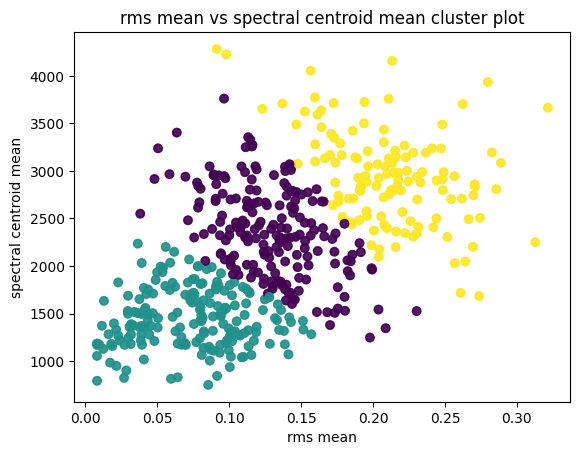

In [159]:
#Cluster plot: rms amplitude mean vs spectral centroid mean

features = merged_df[['rms_mean', 'spectral_centroid_mean']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(scaled_features)

plt.scatter(merged_df['rms_mean'], merged_df['spectral_centroid_mean'], c=clusters, cmap='viridis', alpha=0.7) #viridis is a type of colormap

plt.xlabel('rms mean')
plt.ylabel('spectral centroid mean')
plt.title("rms mean vs spectral centroid mean cluster plot")

plt.show()

<h1>Assumptions Testing</h1>

In [4]:
#Shapiro-Wilk Test to check for normality
#residuals = model_test.resid

stat, p_value = stats.shapiro(merged_df['total_water_loss'])

print("Shapiro-Wilk Test Statistic:", stat)
print("P-Value:", p_value)

if p_value > 0.05:
    print("The data is normally distributed (fail to reject H₀).")
else:
    print("The data is not normally distributed (reject H₀).")

Shapiro-Wilk Test Statistic: 0.9761261864085752
P-Value: 7.874178903555918e-12
The data is not normally distributed (reject H₀).


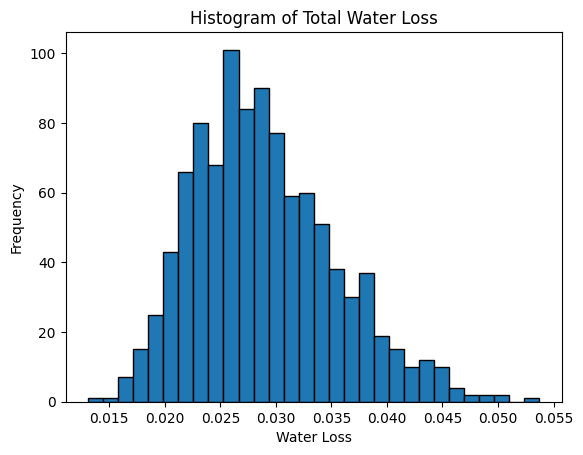

In [19]:
plt.hist(merged_df['total_water_loss'], bins=30, edgecolor='black')
plt.title('Histogram of Total Water Loss')
plt.xlabel('Water Loss')
plt.ylabel('Frequency')
plt.show()

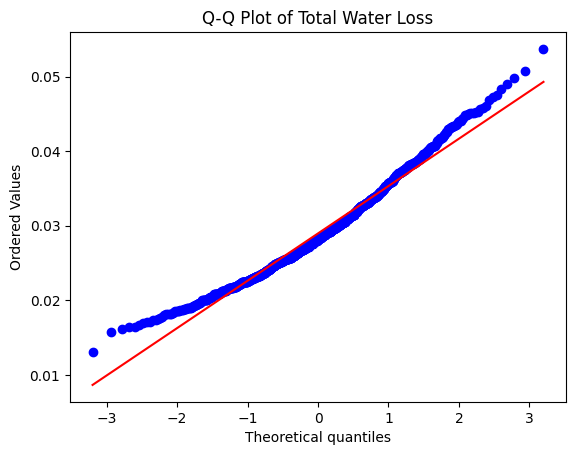

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(merged_df['total_water_loss'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Total Water Loss')
plt.show()


In [8]:
#depricated, but was used to remove datapoint outliers that were 3 std away from the mean. in this case we used in terms of residuals

# std_deviation = np.std(residuals)
# mean_residual = np.mean(residuals)
# threshold = 3  # This can be adjusted

# outliers = merged_df[np.abs(residuals) > (mean_residual + threshold * std_deviation)]
# print("Outliers:")
# print(outliers)

In [9]:
genres = merged_df['genre'].unique()  #get the unique genre names
groups = [merged_df[merged_df['genre'] == genre]['total_water_loss'] for genre in genres]
stat, p_value = stats.levene(*groups)
print("Levene's Test Statistic:", stat)
print("P-Value:", p_value)

if p_value > 0.05:
    print("Variances are equal across groups (fail to reject H₀).")
else:
    print("Variances are significantly different across groups (reject H₀).")

Levene's Test Statistic: 2.6753861233026157
P-Value: 0.004501396519727931
Variances are significantly different across groups (reject H₀).


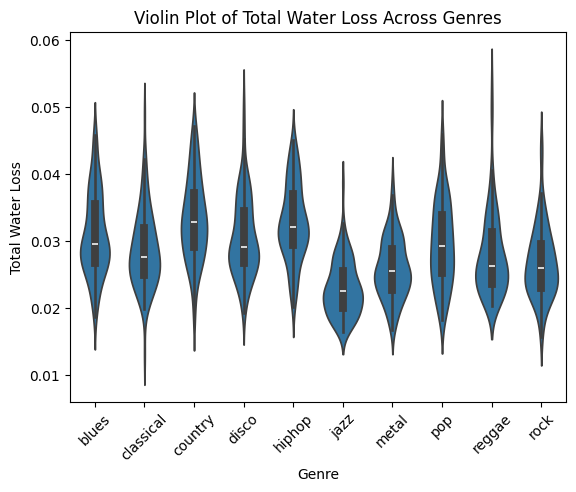

In [10]:
sns.violinplot(x='genre', y='total_water_loss', data=merged_df)
plt.title('Violin Plot of Total Water Loss Across Genres')
plt.xlabel('Genre')
plt.ylabel('Total Water Loss')
plt.xticks(rotation=45)
plt.show()

In [ ]:
for variable in ['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'chroma_stft_mean', 'chroma_stft_var',
                  'rolloff_mean', 'rolloff_var', 'tempo']:
    stat, p_value = stats.shapiro(merged_df[variable])

    print(stat, p_value)

    if p_value > 0.05:
        print("The data is normally distributed (fail to reject H₀).")
    else:
        print("The data is not normally distributed (reject H₀).")

    plt.hist(merged_df[variable], bins=30, edgecolor='black')
    plt.title(f'Histogram of {variable}')
    plt.xlabel(f'{variable}')
    plt.ylabel('Frequency')
    plt.show()

<h1>Spearman's Rank Correlation</h1>

In [20]:
corr_matrix = merged_df[['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'rolloff_mean', 'rolloff_var',
                   'total_water_loss']].corr()

print(corr_matrix)

                         rms_mean   rms_var  spectral_centroid_mean  \
rms_mean                 1.000000  0.584204                0.551078   
rms_var                  0.584204  1.000000                0.302211   
spectral_centroid_mean   0.551078  0.302211                1.000000   
spectral_centroid_var    0.325004  0.541939                0.491150   
spectral_bandwidth_mean  0.580977  0.364144                0.910506   
spectral_bandwidth_var   0.117448  0.344880                0.005978   
zero_crossing_rate_mean  0.382658  0.126873                0.892919   
zero_crossing_rate_var   0.335319  0.518271                0.656625   
rolloff_mean             0.581791  0.334043                0.981398   
rolloff_var              0.197534  0.391319                0.145001   
total_water_loss         0.346979  0.313024                0.133913   

                         spectral_centroid_var  spectral_bandwidth_mean  \
rms_mean                              0.325004                 0.580977 

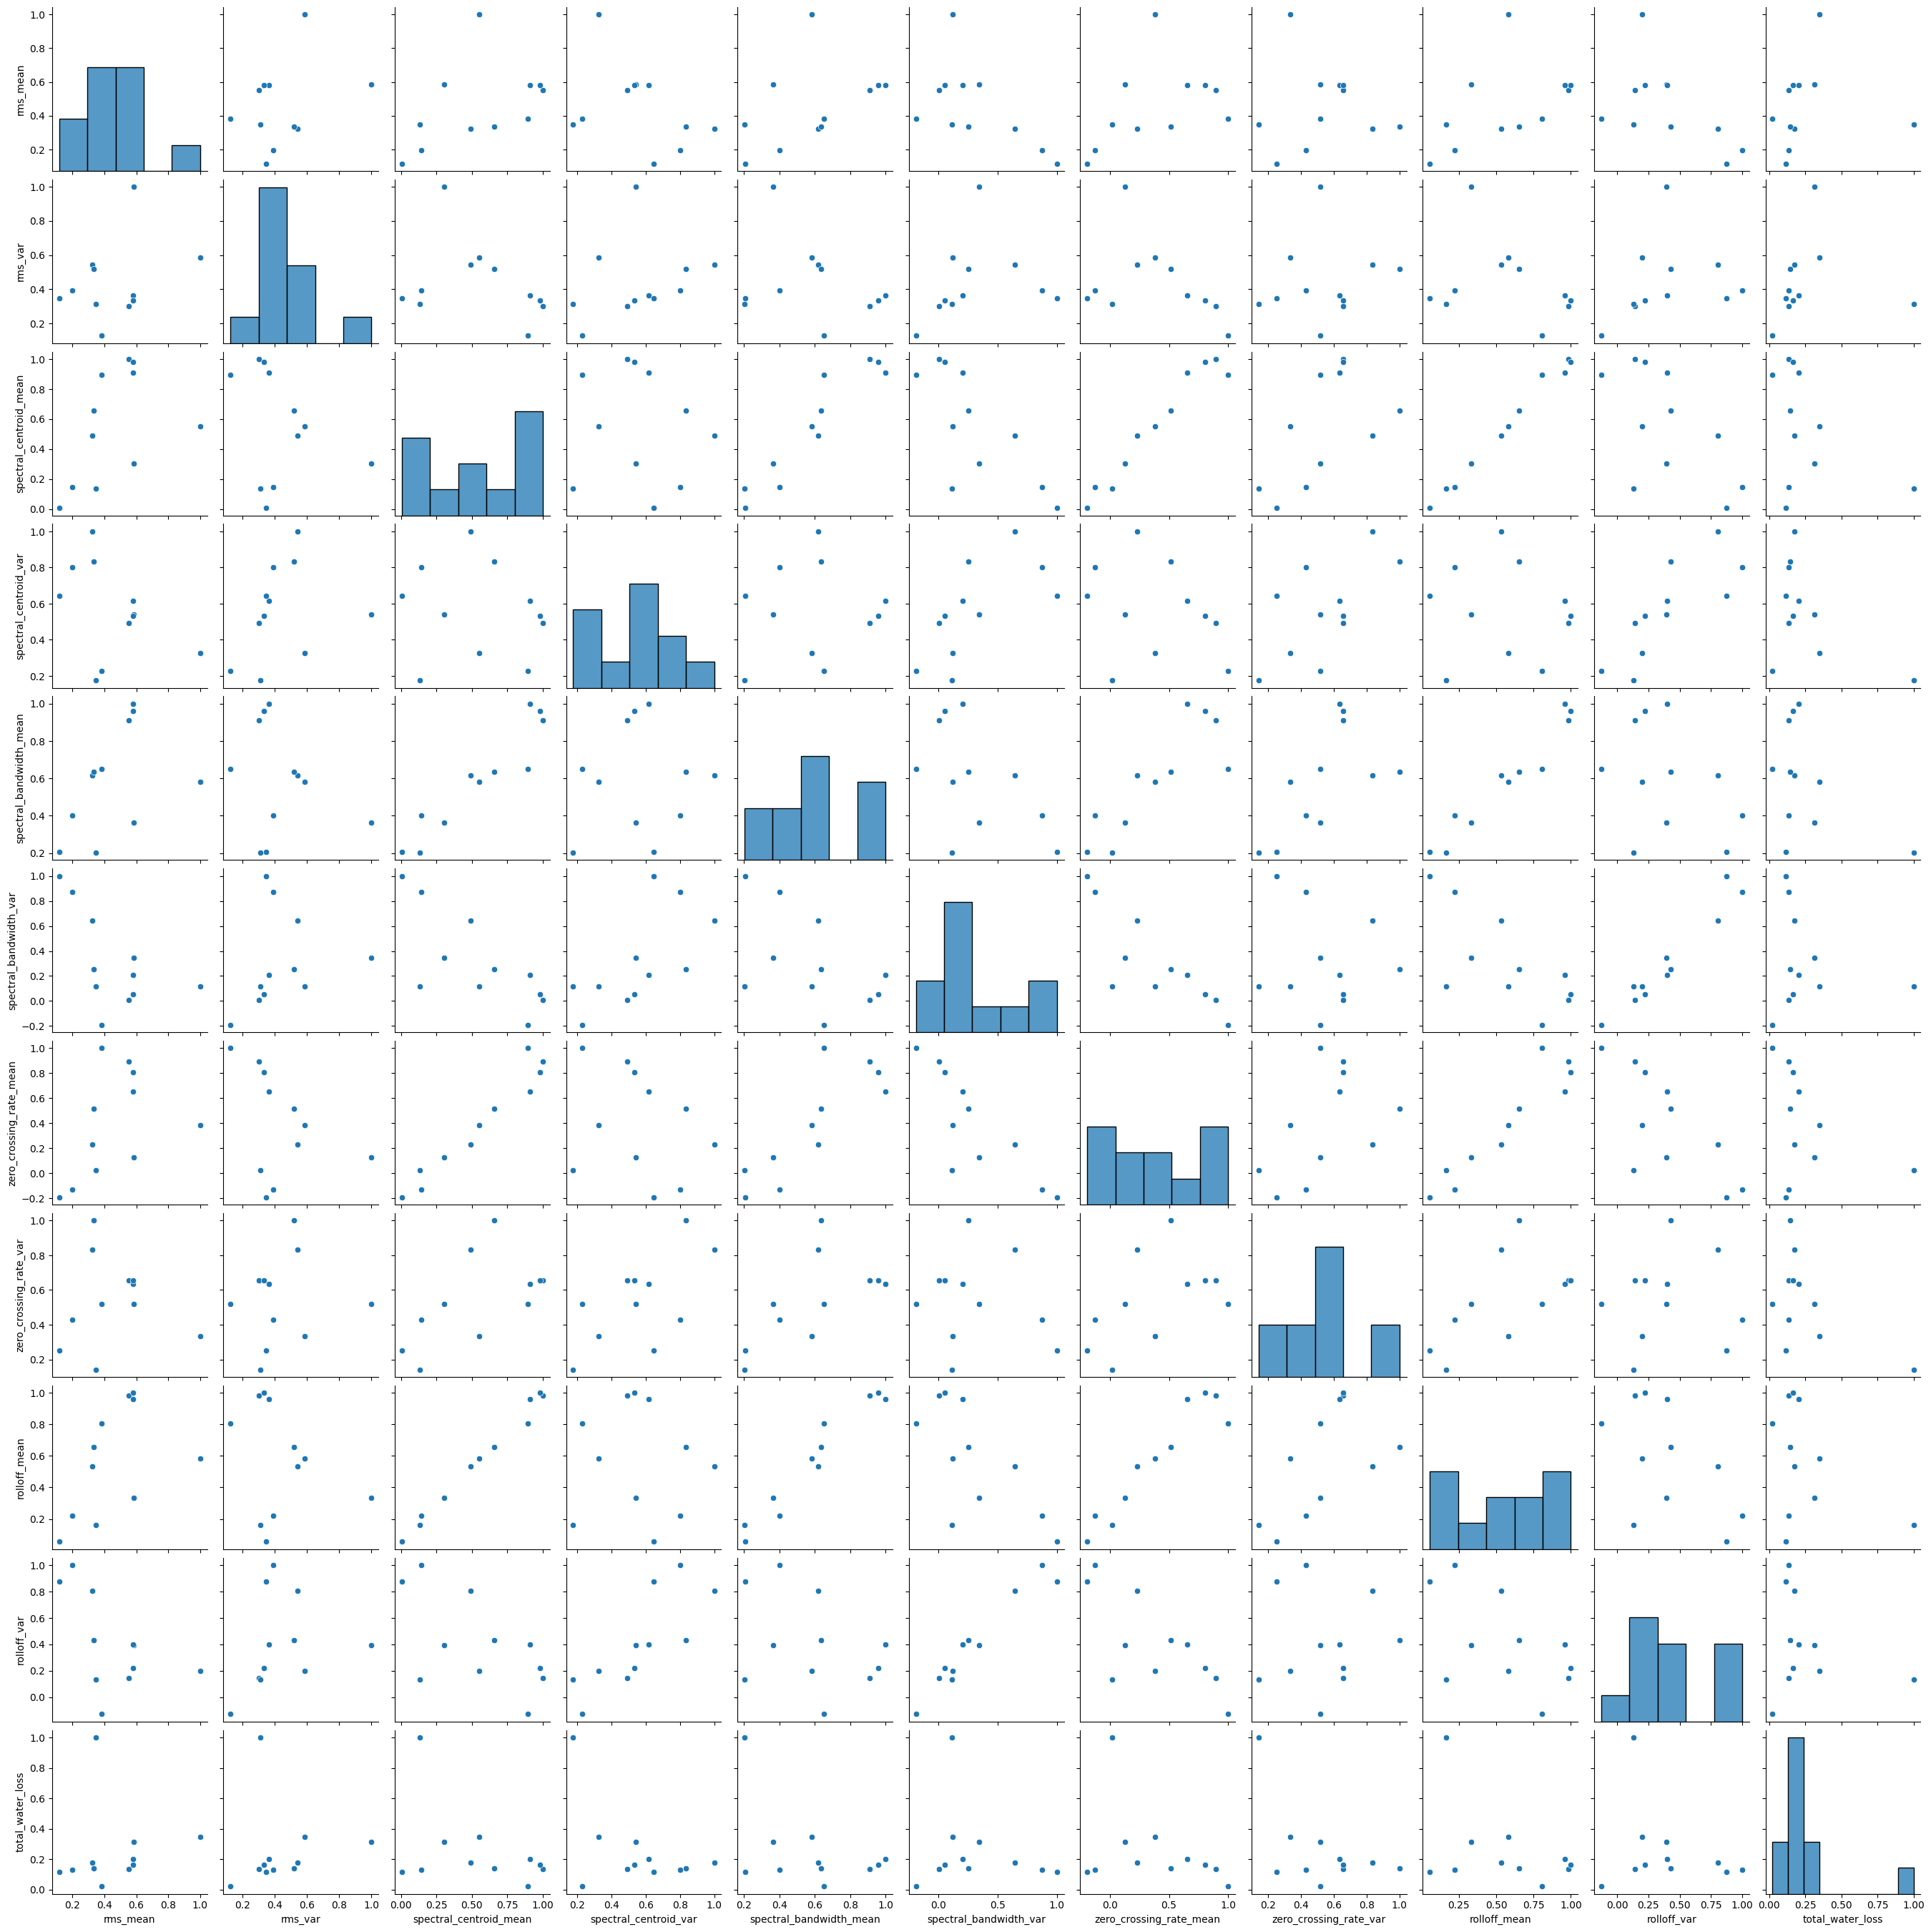

In [21]:
sns.pairplot(corr_matrix)
plt.show()

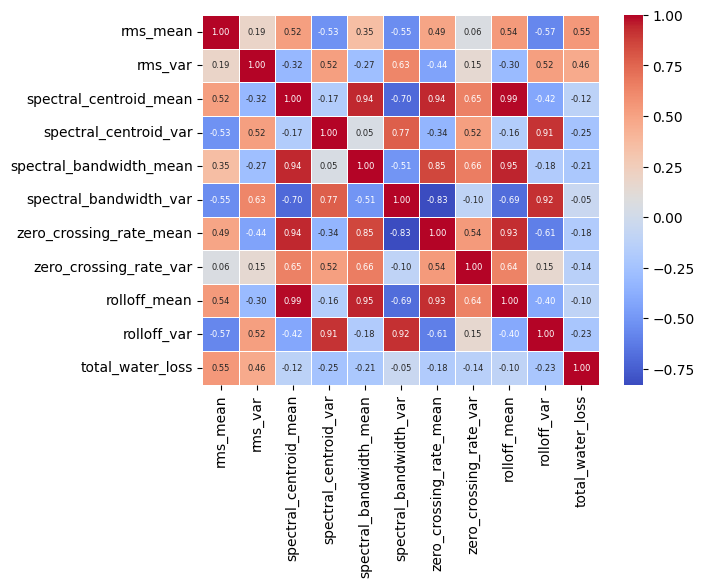

In [22]:
# Calculate Spearman correlation


corr = corr_matrix.corr(method='spearman')

# Plot a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt = '.2f', linewidths = 0.5, annot_kws={"size": 6})
plt.show()

<h1>Welch's ANOVA</h1>


<h3>Independent: song_name,  Dependent: total 
water loss </h3>

In [211]:
welch_anova_results = pg.welch_anova(dv='total_water_loss', between='genre', data=merged_df)

print(welch_anova_results)

  Source  ddof1       ddof2         F         p-unc       np2
0  genre      9  406.881629  41.02769  7.099962e-52  0.224306


<h1>PCA</h1>

In [61]:
outputs = merged_df[['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'rolloff_mean', 'rolloff_var']]

In [62]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(outputs)

In [63]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
print(principal_components)

[[-1.49037811 -0.53154172]
 [-1.49037811 -0.53154172]
 [-1.1349875   1.59279835]
 ...
 [ 2.28972044  5.69968106]
 [ 0.36929422  3.08827415]
 [ 0.36929422  3.08827415]]


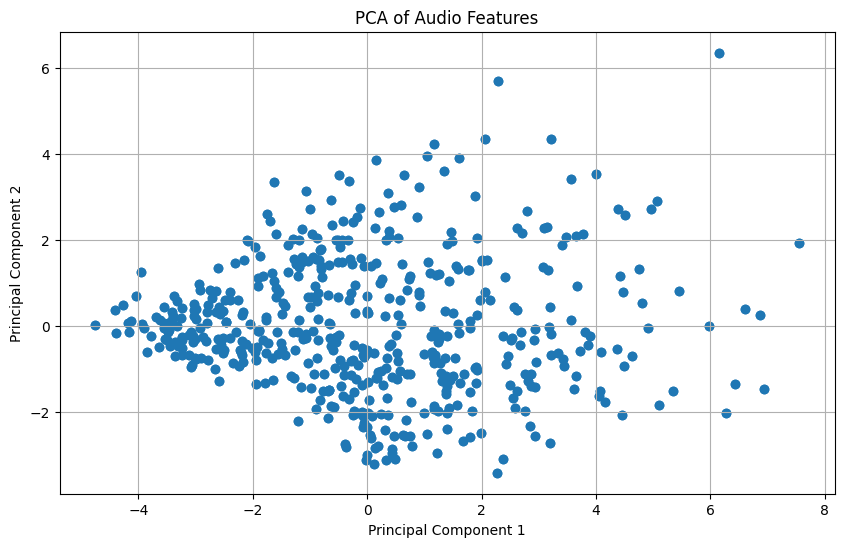

In [64]:
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('PCA of Audio Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

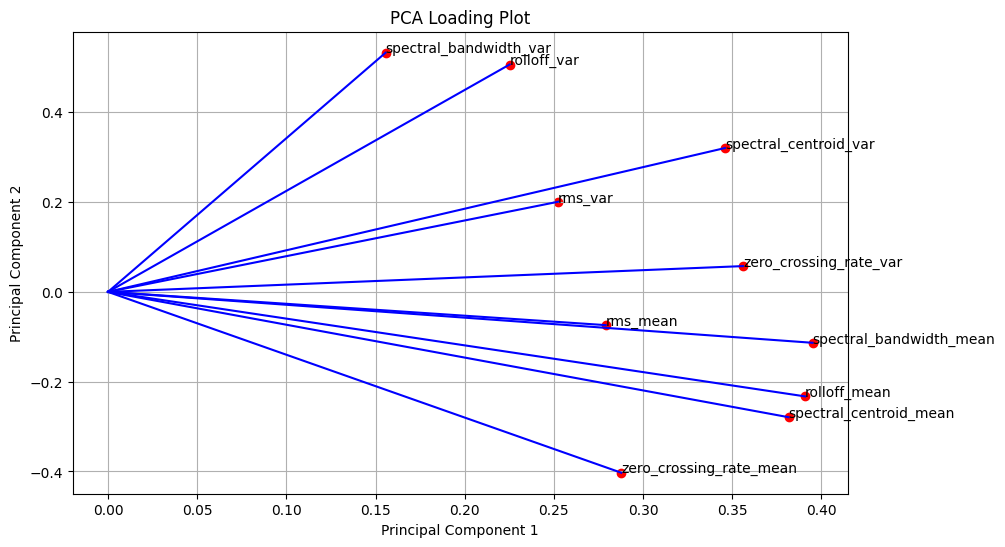

In [65]:
loadings = pca.components_

plt.figure(figsize=(10, 6))
plt.scatter(loadings[0, :], loadings[1, :], color='red')
for i in range(loadings.shape[1]):
    plt.plot([0, loadings[0, i]], [0, loadings[1, i]], 'blue')

feature_names = ['rms_mean', 'rms_var', 
                  'spectral_centroid_mean', 'spectral_centroid_var', 
                  'spectral_bandwidth_mean', 'spectral_bandwidth_var',
                  'zero_crossing_rate_mean', 'zero_crossing_rate_var',
                  'rolloff_mean', 'rolloff_var']

for i, feature in enumerate(feature_names):
    plt.text(loadings[0, i], loadings[1, i], feature)

plt.title('PCA Loading Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

<h1>Ridge Regression</h1>

In [66]:
X = merged_df[['rms_mean', 'rms_var', 
               'spectral_centroid_mean', 'spectral_centroid_var', 
               'spectral_bandwidth_mean', 'spectral_bandwidth_var',
               'zero_crossing_rate_mean', 'zero_crossing_rate_var',
               'rolloff_mean', 'rolloff_var',
               ]]

y = merged_df['total_water_loss']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [70]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [71]:
ridge_reg = Ridge(alpha=1.0)

# Train the model
ridge_reg.fit(X_train_scaled, y_train)


Ridge()

In [72]:
y_pred = ridge_reg.predict(X_test_scaled)


In [73]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


Mean Squared Error: 3.329730136793369e-05
R-squared: 0.16106249566615038


In [74]:
coefficients = pd.Series(ridge_reg.coef_, index=X.columns)
print(coefficients)


rms_mean                   0.001708
rms_var                    0.000943
spectral_centroid_mean    -0.001242
spectral_centroid_var      0.001180
spectral_bandwidth_mean    0.004270
spectral_bandwidth_var     0.000825
zero_crossing_rate_mean   -0.000345
zero_crossing_rate_var     0.000027
rolloff_mean              -0.003057
rolloff_var               -0.002398
dtype: float64
